In [ ]:
import os 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors
from matplotlib import lines
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import statsmodels.api as sm
import itertools
import itertools
import scanpy as sc
import anndata as ad
import episcanpy.api as epi
import sys
sys.path.append("../")
from utils.scattermap import scattermap
from scipy.stats import ttest_ind, mannwhitneyu
import gseapy
from plot_utils import *
import sszpalette
# register the ssz color palette
colorsmaps = sszpalette.register()
from utils.supervenn import *
#from clusteringMethods import *
%matplotlib inline

In [2]:
model_path = "../cellformer/deconvoluted/"
data = "../data/deconvoluted_ct.h5ad"
annot_key="nearestGeneChip"
comparison="label"
pairs = [("NC", "RAD"), ("NC", "ADD"), ("RAD", "ADD")]
if not os.path.exists(model_path):
        os.mkdir(model_path)
savepath = model_path + comparison+ "/"
if not os.path.exists(savepath):
    os.mkdir(savepath)

# Load Data

In [3]:
adata = ad.read_h5ad(data)

adata = adata[adata.obs[comparison] != "Na"]
adata.obs[comparison].unique()

['NC', 'RAD', 'ADD']
Categories (3, object): ['ADD', 'NC', 'RAD']

# DE

In [4]:
group="RAD"
df_gene = []
FC = 0.5
pval = 0.01
term_list = []
df_gene_promoter = []
for ba in adata.obs.brain_region.unique():
    print(ba)
    for ct in adata.obs.celltype.unique():
        print(ct)
        
        dat = adata[(adata.obs.celltype == ct)&(adata.obs.brain_region==ba),:]
        dat.var_names = dat.var["nearestGeneChip"].astype(str).values #+"_"+ tmp.var.index.astype(str).tolist()
        dat.var_names_make_unique()
        dat.var["names"] = dat.var_names.values
        sc.tl.rank_genes_groups(dat,  comparison, method='wilcoxon', 
                                rankby_abs=True,
                   
                                #gene_symbols="peakid",
                                key_added = "wilcoxon")
 
        glist = sc.get.rank_genes_groups_df(dat, group=group, gene_symbols="peakid",
                                        key='wilcoxon', #log2fc_min=0.25, 
                                        )#['names'].squeeze().str.strip().tolist()
        glist = glist.merge(dat.var, on="names")
        min_pval = glist[glist.pvals_adj>0]["pvals_adj"].min()
        glist.loc[glist.pvals_adj==0, "pvals_adj"] = min_pval
        glist["celltype"] = ct
        glist["brain_region"] = ba
        glist.loc[glist["logfoldchanges"].isna(),"logfoldchanges"] =0        
        df_gene.append(glist)#[glist.pvals_adj <pval])
        tmp = dat[:, dat.var["shortAnnotChip"] == "Promoter"]
        tmp.var.reset_index(inplace=True, drop=True)
        tmp.var_names = tmp.var["nearestGeneChip"].astype(str).values #+"_"+ tmp.var.index.astype(str).tolist()
        tmp.var_names_make_unique()
        tmp.var["names"] = tmp.var_names.values

        sc.tl.rank_genes_groups(tmp, comparison, method='wilcoxon', 
                                 #groups=groups,
                                #reference=reference,
                                rankby_abs=True,
                                key_added = "wilcoxon")
        glist = sc.get.rank_genes_groups_df(tmp, group=group, #gene_symbols="peakid",
                                        key='wilcoxon') #log2fc_min=0.25, 
                                       # pval_cutoff=1)#['names'].squeeze().str.strip().tolist()
        glist = glist.merge(tmp.var, on="names")
        min_pval = glist[glist.pvals_adj>0]["pvals_adj"].min()
        glist.loc[glist.pvals_adj==0, "pvals_adj"] = min_pval
        glist["celltype"] = ct
        glist["brain_region"] = ba
        glist.loc[glist["logfoldchanges"].isna(),"logfoldchanges"] =0  
        de=glist#[glist.pvals_adj]
        df_gene_promoter.append(glist)

CAUD
AST


EXC
INH
MIC
OPCs
OLD
SMTG
AST
EXC
INH
MIC
OPCs
OLD
HIPP
AST
EXC
INH
MIC
OPCs
OLD


In [5]:
comp = "ll"
if comp == "promoters":
    savepath += "promoters"
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    df_tot = pd.concat(df_gene_promoter)
else:
    df_tot = pd.concat(df_gene)
df_tot["abs_scores"] = np.abs(df_tot["scores"]).values
df_tot["-log(q-value)"] = -np.log(df_tot["pvals_adj"]).values
df_tot["peakid"] = df_tot["peakid_x"].values
df_tot.to_csv(savepath + "DE_peaks_pval_%s_FC_%s.csv"%(pval, FC))
df_tot


,names,scores,logfoldchanges,pvals,pvals_adj,peakid_x,nearestGeneChip,nearestGene,peakType,peakid_y,shortAnnotChip,start,celltype,brain_region,abs_scores,-log(q-value),peakid
0,ZNF181,4.555504,0.605298,0.000005,0.05069,chr19_34732700_34733200,ZNF181,ZNF181,Promoter,chr19_34732700_34733200,Promoter,34732700,AST,CAUD,4.555504,2.982033,chr19_34732700_34733200
1,MIR4521,4.501164,0.639376,0.000007,0.05069,chr17_8185123_8185623,MIR4521,BORCS6,Distal,chr17_8185123_8185623,Distal Intergenic,8185123,AST,CAUD,4.501164,2.982033,chr17_8185123_8185623
2,AASDH-1,4.492107,0.473435,0.000007,0.05069,chr4_56389436_56389936,AASDH,AASDH,Distal,chr4_56389436_56389936,Distal Intergenic,56389436,AST,CAUD,4.492107,2.982033,chr4_56389436_56389936
3,STARD9,4.419654,0.543063,0.000010,0.05069,chr15_42574026_42574526,STARD9,STARD9,Promoter,chr15_42574026_42574526,Distal Intergenic,42574026,AST,CAUD,4.419654,2.982033,chr15_42574026_42574526
4,ZBTB41,4.365314,0.748442,0.000013,0.05069,chr1_197189536_197190036,ZBTB41,ZBTB41,Intronic,chr1_197189536_197190036,Intron,197189536,AST,CAUD,4.365314,2.982033,chr1_197189536_197190036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41949,PLEKHG1-9,0.000000,0.000000,1.000000,1.00000,chr6_150811900_150812400,PLEKHG1,MTHFD1L,Intronic,chr6_150811900_150812400,Intron,150811900,OLD,HIPP,0.000000,-0.000000,chr6_150811900_150812400
41950,PLEKHG1-8,0.000000,0.000000,1.000000,1.00000,chr6_150749080_150749580,PLEKHG1,MTHFD1L,Intronic,chr6_150749080_150749580,Intron,150749080,OLD,HIPP,0.000000,-0.000000,chr6_150749080_150749580
41951,IYD,0.000000,0.000000,1.000000,1.00000,chr6_150286867_150287367,IYD,IYD,Distal,chr6_150286867_150287367,Distal Intergenic,150286867,OLD,HIPP,0.000000,-0.000000,chr6_150286867_150287367
41952,RAET1K,0.000000,0.000000,1.000000,1.00000,chr6_150004464_150004964,RAET1K,RAET1L,Distal,chr6_150004464_150004964,Promoter,150004464,OLD,HIPP,0.000000,-0.000000,chr6_150004464_150004964


# Figures

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AST
SMTG
EXC
SMTG
INH
SMTG
OPCs
SMTG
OLD
SMTG


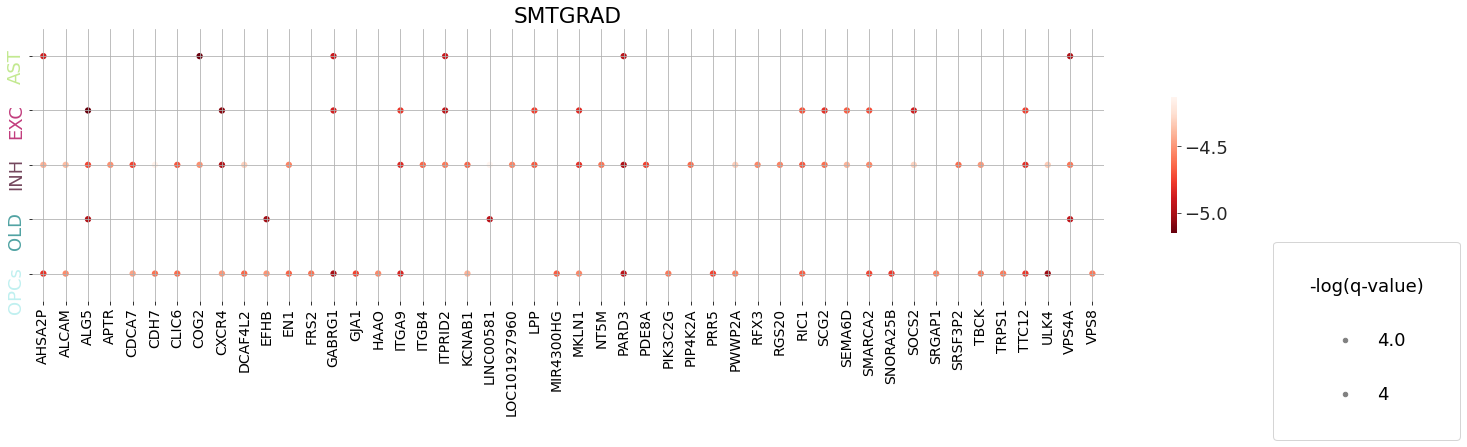

In [6]:
### Plot top enriched OCR

ba = "SMTG"
df_tmp =df_tot[df_tot.brain_region == ba]
_, top_genes = get_top_gene(df_tmp, pval=0.01)
df_tmp =df_tmp[df_tmp["names"].isin(top_genes)]
df_tmp
df_tmp =df_tmp[df_tmp.pvals_adj<0.01]
plot_dotplot(df_tmp, savepath=savepath, savename=ba+group, key_color="scores", key_size="-log(q-value)", cmap="Reds_r")

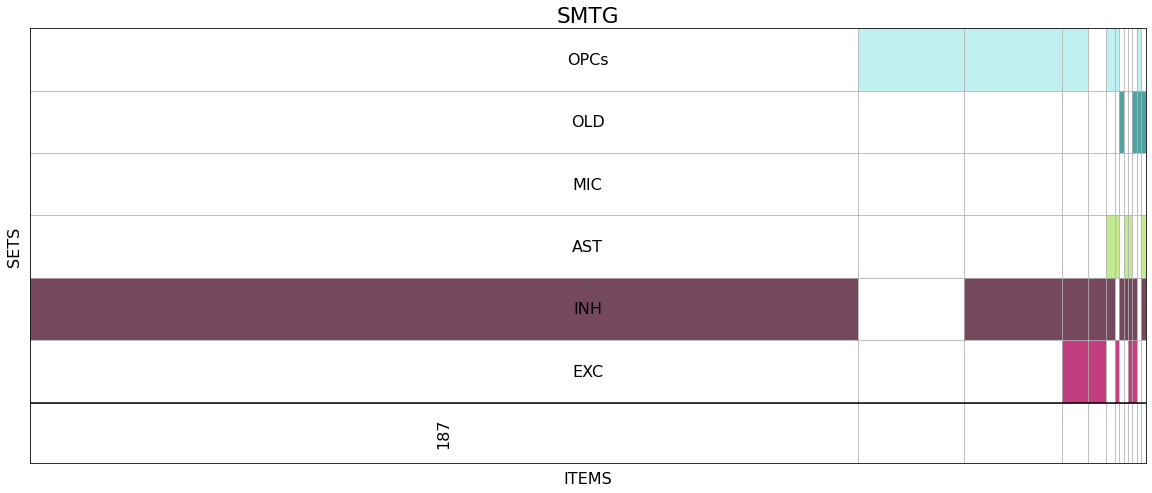

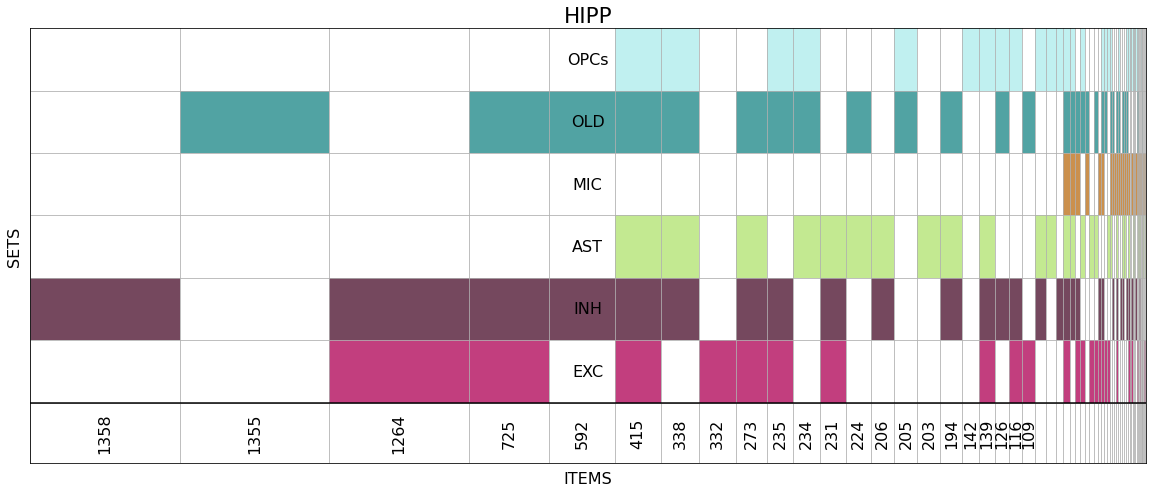

In [7]:
### supervenn cell type specific peaks

plotVennCelltype(df_tot[df_tot.brain_region.isin(["SMTG", "HIPP"])],
                            "AD",
                              savepath.rsplit("/",2)[0],
                              FC=0.5,
                                pval=0.01,
                            x="logfoldchanges",
                              y = "-log(q-value)")

0.2033898305084746
0.31026252983293556
3.1013395457192776
0.0
2.1721958925750395
0.05543237250554324


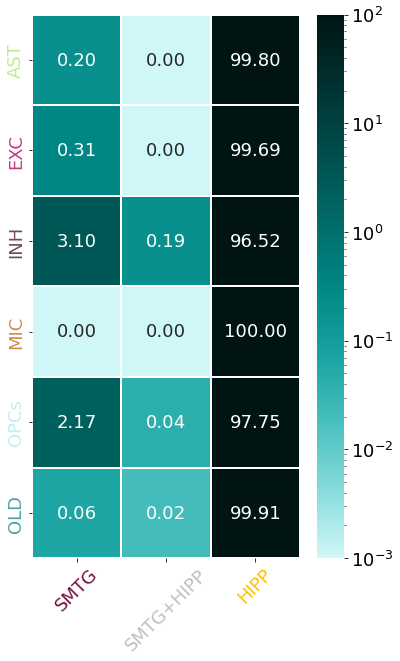

In [8]:
### overlap between brain regions
heatmapRegion(df_tot,
                "AD",
                [ "SMTG", "HIPP"],
                savepath.rsplit("/", 2)[0],
                FC=0.5,
                pval=0.01,
                x="logfoldchanges"
                )

# GO

In [12]:

name="nearestGeneChip"
term_list = []
if comp=="promoters":
    background = adata[:, adata.var["shortAnnotChip"] =="Promoters"].var[name].unique().tolist()
    FC=0.5
else:
    background = adata.var[name].unique().tolist()
    FC=0.5
    
df_tot = df_tot[df_tot.celltype!="bulk"]
for ba in adata.obs.brain_region.unique():
    print(ba)
    for ct in adata.obs.celltype.unique():
        print(ct)
        tmp_ada = df_tot[(df_tot.celltype == ct)&(df_tot.pvals_adj<=pval)&(df_tot.brain_region==ba)]
        all_genes = tmp_ada[np.abs(tmp_ada["logfoldchanges"]) >FC ]#["names"].values.tolist()
        if len(all_genes)>0:

            all_genes =all_genes[[name,"logfoldchanges"]]#.set_index(name)
            all_genes = all_genes.sort_values("logfoldchanges", ascending=False)
            tmp = get_go(all_genes[name].values.tolist(), background )#

            tmp["celltype"] = ct
            tmp["brain_region"] = ba
            tmp["regulation"] = "all"
            term_list.append(tmp)


CAUD
AST
EXC
INH
MIC
OPCs
OLD
SMTG
AST
EXC
INH
MIC
OPCs
OLD
HIPP
AST
EXC
INH
MIC
OPCs
OLD


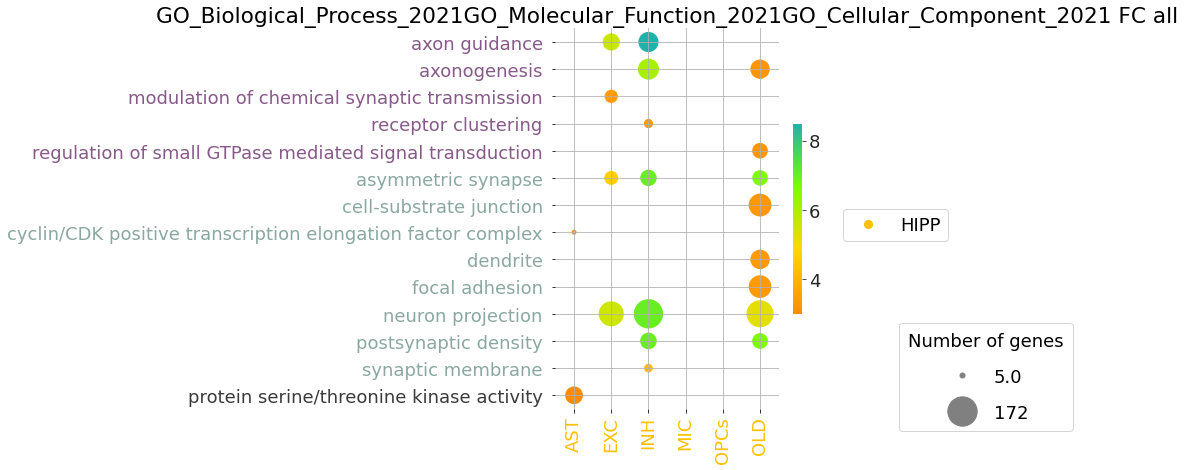

In [13]:
termss = pd.concat(term_list)
termss["comparison"] = "RADvsAll"#%group
termss["-log(p-value)"] = -np.log(termss["Adjusted P-value"].astype(float).values+1e-10)
termss["overlap_ratio"] = termss["Overlap"].str.split("/", expand=True)[0].astype(int) / termss["Overlap"].str.split("/", expand=True)[1].astype(int)
termss["Number of genes"] = termss["Overlap"].str.split("/", expand=True)[0].astype(int) 
score = "overlap_ratio"
min_n =np.abs(termss[score]).min()
max_n =np.abs(termss[score]).max()
termss2 = termss[termss["Number of genes"] >=2]

termss2 = termss2[termss2["Adjusted P-value"] <0.05]
reg = "all"
plot_GO(termss2[(termss2["regulation"]==reg)&(termss2["Gene_set"].str.contains("GO"))],
        ["HIPP"],
        df_tot["celltype"].unique().tolist(),
        savepath + "HIPPOnlyenrichr_FC_%s_pval%s_BioP"%(FC,pval) + reg, reg,
        score_key = "Number of genes",
        mix_brain_region=False)

# TOP dysregulated OCR

In [ ]:
ct=""
conc_pp =[]
conc_tot = []
sns.set(font_scale=2, style="white")
for ct in ["MIC","OPCs", "AST", "EXC","INH", "OLD"]:
    oligo = df_tot[(df_tot.celltype==ct) &(df_tot.brain_region=="HIPP")&(df_tot.pvals_adj <=pvals)&(np.abs(df_tot.logfoldchanges)>=FC)]
    pp = oligo.groupby(["nearestGeneChip"])["names"].count()
    ff = pp[pp!=0].sort_values(ascending=False).reset_index()
    ff.columns = ["Gene", "count"]
    ff["count"] =ff["count"].astype(int)
    ff["celltype"] = ct
    ff = ff[ff["count"] >1]
    conc_tot.append(ff)
    pp = pp[pp!=0].sort_values(ascending=False).reset_index().iloc[:20,:]
    pp = pp.sort_values(["names","nearestGeneChip"], ascending=[False, True])
    pp.columns = ["Gene", "count"]
    pp["count"] =pp["count"].astype(int)
    pp["celltype"] = ct
    conc_pp.append(pp)
    pp = pp[pp["count"] >1]

conc_pp =pd.concat(conc_pp)
conc_tot =pd.concat(conc_tot)
conc_tot
tt = adata.var.groupby(["nearestGeneChip"])["peakid"].size().reset_index()
tt.columns = ["Gene", "total_count"]
conc_t = conc_tot.merge(tt, on="Gene")
conc_t["ratio"] = conc_t["count"].values/conc_t["total_count"].values
conc_t

name="nearestGeneChip"
term_list = []
if comp=="promoters":
    background = adata[:, adata.var["shortAnnotChip"] =="Promoters"].var[name].unique().tolist()
    FC=0.5
else:
    background = adata.var[name].unique().tolist()
    FC=0.5
hh = conc_t[conc_t.ratio==1.0]
hh_ratio1 = conc_t[conc_t.ratio>0.5]

top20 = pd.DataFrame(hh_ratio1.groupby('celltype')['count'].nlargest(20)).reset_index()
top_20_t = hh_ratio1.loc[top20["level_1"].values,:]
top_20_t

ff = conc_t[conc_t.Gene.isin(top_20_t["Gene"].unique().tolist())]
ff

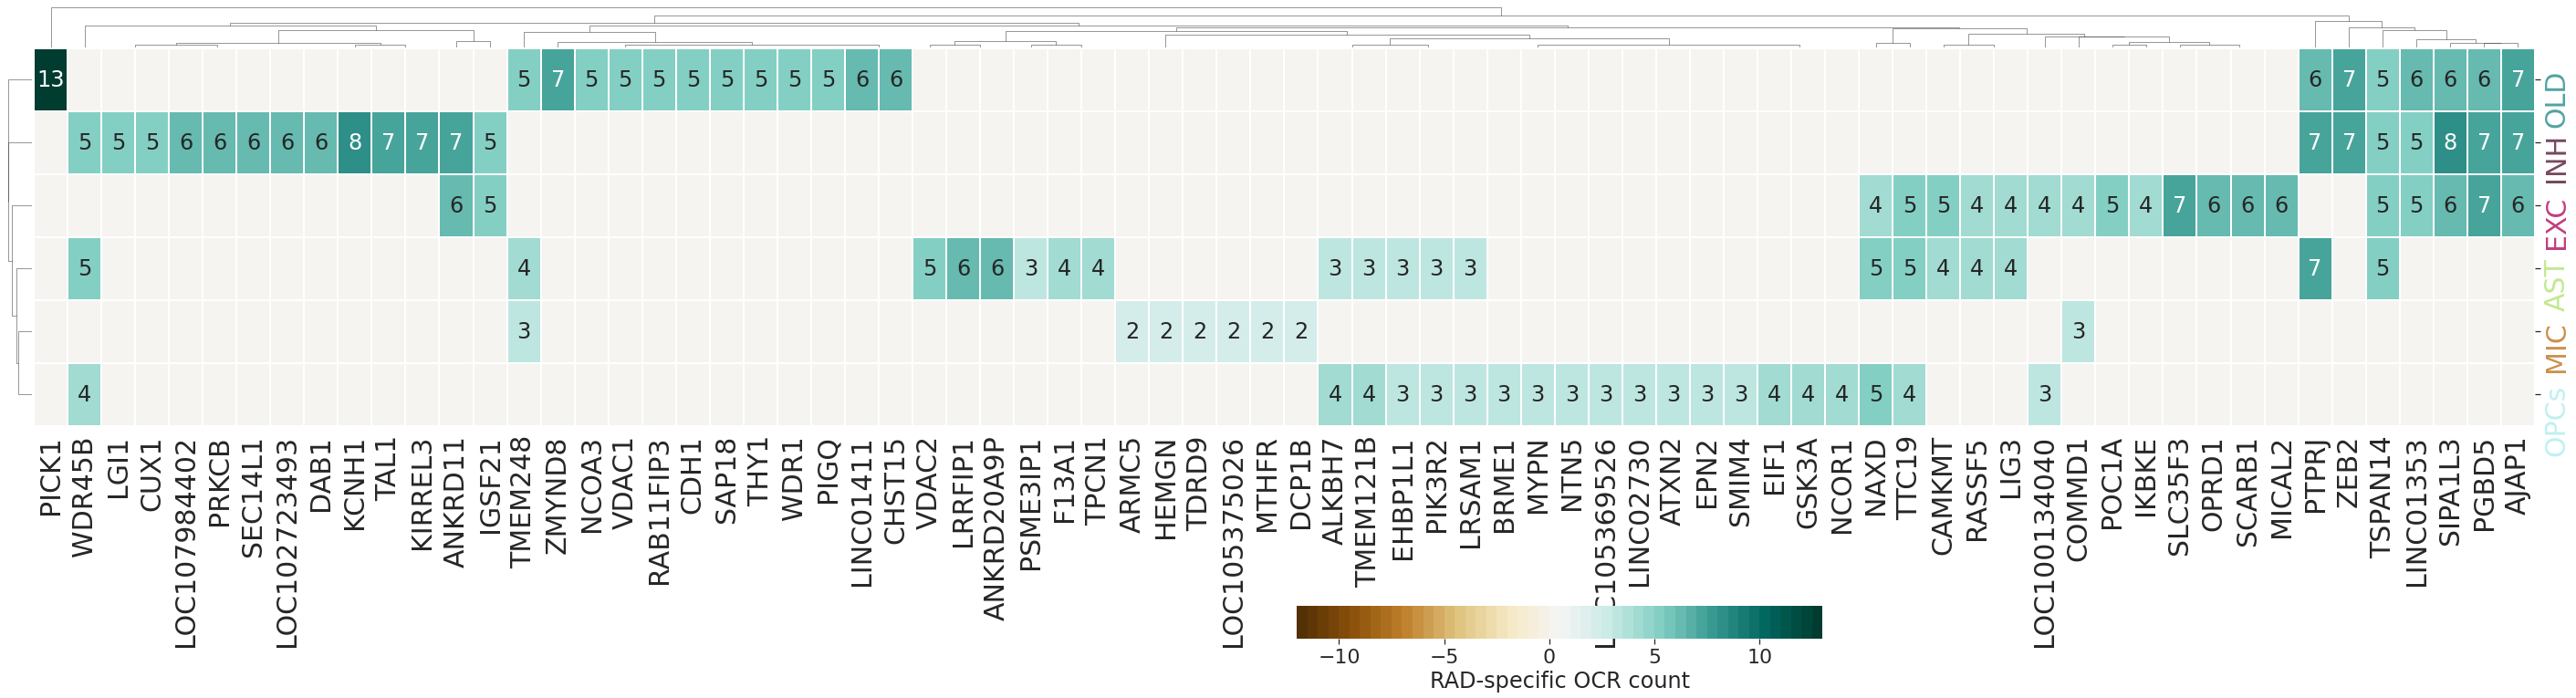

In [15]:
#ppi = hh_ratio1.pivot(index="celltype", columns="nearestGeneChip", values="names")
colors_ct = {"Neur":"#75485E","EXC":"#C23E7E", "INH":"#75485E","OLD":"#51A3A3","OPCs":"#C0F0F0", "MIC":"#CB904D", "AST":"#C3E991"}

ppi = top_20_t.pivot(index="celltype", columns="Gene", values="count")
ppi.fillna(0,inplace=True)
cmap = cm.get_cmap('BrBG', 50)
annot = ppi.copy().astype(int).astype(str)
annot[annot == "0"] = " "
sns.set(font_scale=2, style="white")

g = sns.clustermap(ppi, cmap=cmap, 
               figsize=(40,10), dendrogram_ratio=(0.01, 0.1), linewidth=0.2, vmin=-12,
               annot=annot,fmt="s",
              cbar_pos=(0.5, 0, .2, .05),
              cbar_kws={"label":"RAD-specific OCR count", "orientation":"horizontal"})
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
for label in (ax.get_yticklabels()):

                cc = label.get_text()
                
                label.set(color=colors_ct[cc], label=cc, rotation=90
                          , fontsize=30)
ax.tick_params(labelsize=30)
plt.savefig(savepath + "ALLheatmapTop_RATIO1_20_most_occurent_gene_RAD_" + str(FC) + str(pvals) + ".svg", bbox_inches="tight")


# RAD-specific OCR composition

In [16]:
df_nb_peaks_per_celltype = {}

for ct in adata.obs.celltype.unique():
    tmp = adata[adata.obs.celltype==ct].X
    tmp = tmp[:,(tmp!=0).any(axis=0)]
    df_nb_peaks_per_celltype[ct] = tmp.shape[1]
df_nb_peaks_per_celltype

{'AST': 19996,
 'EXC': 22864,
 'INH': 31425,
 'MIC': 10145,
 'OPCs': 22031,
 'OLD': 32971}

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.0, 'AST')
Text(0, 1.0, 'EXC')
Text(0, 2.0, 'INH')
Text(0, 3.0, 'MIC')
Text(0, 4.0, 'OLD')
Text(0, 5.0, 'OPCs')


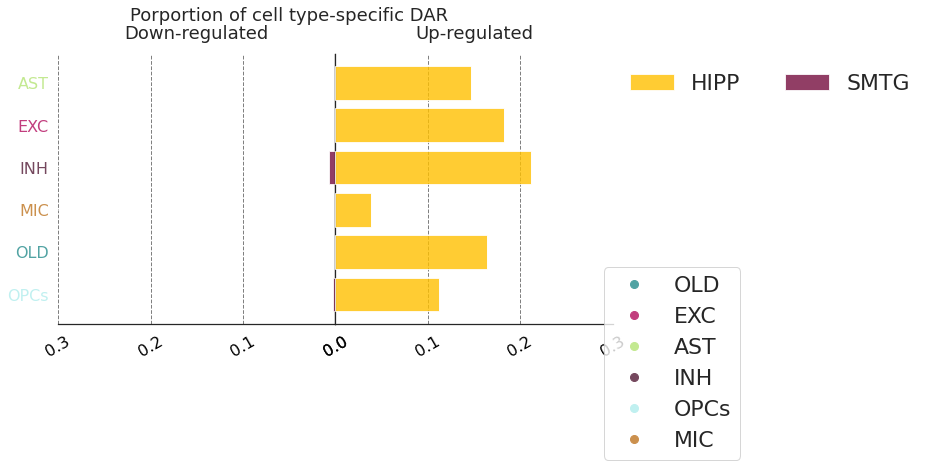

In [24]:
df_tot["test_cond"] = "RAD" #df_tot["condition1"].apply(lambda x: eval(x)[0]).values + df_tot["condition2"].apply(lambda x: eval(x)[0]).values
x="logfoldchanges"
pvals_c="pvals_adj"

df_tot_de = df_tot[(df_tot[pvals_c] <=pval)& (np.abs(df_tot[x])>=FC)]
df_tot_de["UpRegulated"] = (df_tot_de[x]>0).values.astype(int)
df_tot_de["DownRegulated"] = (df_tot_de[x]<0).values.astype(int)

columns = ["brain_region", "celltype", "test_cond", "UpRegulated", "DownRegulated"]
tt = df_tot_de[columns].groupby(["test_cond", "brain_region", "celltype"]).sum().reset_index()
tt = tt[tt.celltype != "bulk"]
up = tt.pivot(index=["test_cond", "brain_region"], columns="celltype", values="UpRegulated").fillna(0)
down = tt.pivot(index=["test_cond", "brain_region"], columns="celltype", values="DownRegulated").fillna(0)
for it in up.columns:
    up[it] = up[it]/float(df_nb_peaks_per_celltype[it])
    down[it] = down[it]/float(df_nb_peaks_per_celltype[it])
up = up.reset_index(0).drop("test_cond", axis=1).T
down = down.reset_index(0).drop("test_cond", axis=1).T

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout()

celltype = ["EXC", "INH", "AST", "MIC", "OLD", "OPCs"]#tt.celltype.unique().tolist()
brain_regions = up.columns.tolist()
color_cond = {"Neur":"#75485E","EXC":"#C23E7E", "INH":"#75485E", "Glials":"#51A3A3","AST-OPCs-OLD":"#51A3A3", "OPCs-Oligo":"#51A3A3","OLD":"#51A3A3","OPCs":"#C0F0F0", "MIC":"#CB904D", "AST":"#C3E991",
               "bulk":"#cccccc", "CTRH":"#B6F2EC", "SPOR":"#F7D7C8"}
colors = {"CAUD":[18/255.,50/255.,59/255., 1], "SMTG":[118/255.,14/255.,63/255.,1], "PARL":[92/255.,64/255.,77/255.,1],"HIPP":[255/255., 192/255.,0, 1] }

#color_cond= {"NCADD":"#262730","ADD":"#F57764", "RADOther":"#77BA99"}
left1 = len(up) * [0]
left2 = len(down) * [0]
index = up.index#.map('|'.join)
for idx, name in enumerate(brain_regions):
    axes[0].barh(index, down[name], left = left1, color=colors[name],zorder=10, align="center", alpha=0.8)
    axes[1].barh(index, up[name], left = left2, color=colors[name],zorder=10, align="center", alpha=0.8)
    left1 = left1 + down[name]
    left2 = left2 + up[name]


axes[1].set_title("Up-regulated", fontsize=18, pad=15)
axes[0].set_title("Down-regulated", fontsize=18, pad=15)
            
# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()
    
axes[0].set(yticks=index, yticklabels=index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='white') # tick color

axes[1].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)


font_color = 'black'
tmp = []
for label in (axes[0].get_xticklabels()):
    label.set(fontsize=16, color=font_color, rotation=30)
for label in (axes[1].get_xticklabels()):
    label.set(fontsize=16, color=font_color, rotation=30)
for label in (axes[0].get_yticklabels()):
    txt = label.get_text()#.split("|")[1]
    cond = label.get_text()#.split("|")[0]
    tmp.append(cond)
    label.set(color=color_cond[cond], label=str(txt), fontsize=16 )

labels = [item.get_text() for item in axes[0].get_yticklabels()]

axes[0].set_yticklabels(labels,fontsize=16)    
axes[1].yaxis.set_ticks_position('none') 

axes[0].set_axisbelow(True)
axes[0].xaxis.grid(color='gray', linestyle='dashed')
axes[1].set_axisbelow(True)
axes[1].xaxis.grid(color='gray', linestyle='dashed')

max_x = max(max(axes[0].get_xticks()),max(axes[1].get_xticks()))
axes[0].set_xlim(max_x,0)
axes[1].set_xlim(0,max_x)
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
plt.suptitle("Porportion of cell type-specific DAR", fontsize=18)
leg1 = plt.legend(brain_regions, bbox_to_anchor=([0.99, 1, 0, 0]), ncol=4, frameon=False)
ll = []
for it in list(set(tmp)):
    blue_line = lines.Line2D([], [], color=color_cond[it], 
                                        marker="o",
                                        linestyle='None',
                                        markersize=8, label=it)
    ll.append(blue_line)
leg2 = plt.legend(handles=ll, bbox_to_anchor=(1.5, 0.25))

axes[1].add_artist(leg1)
plt.savefig(savepath +"DAR_promoter_only"+ ".svg", bbox_inches="tight")
plt.show()

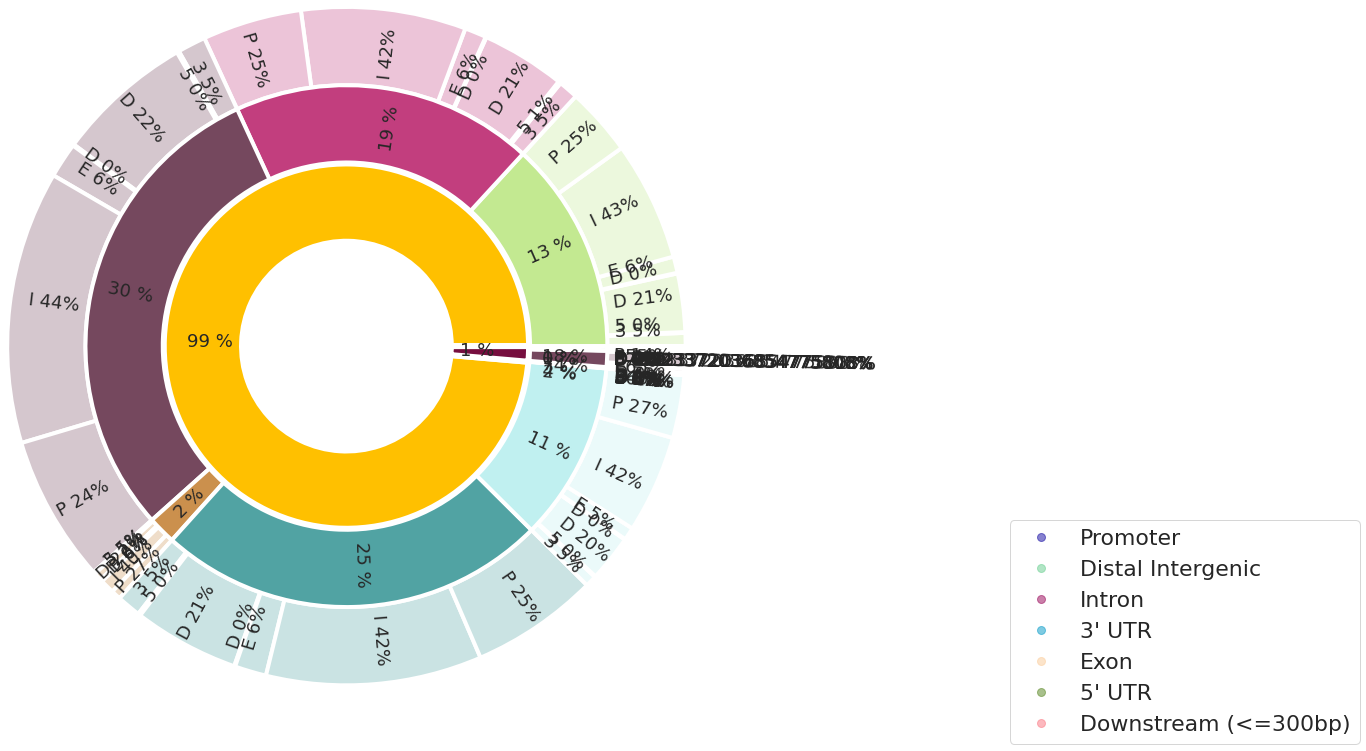

In [25]:
from matplotlib import lines
import sszpalette
colorsmaps = sszpalette.register()
celltypes =adata.obs.celltype.unique()
x="logfoldchanges"
pvals_c="pvals_adj"
tot_peaks_per_region = np.sum([df_nb_peaks_per_celltype[it] for it in celltypes])
df_tot_de = df_tot[(df_tot[pvals_c]<= pval)&(np.abs(df_tot[x])>= FC)]
df_de = df_tot_de[["test_cond", "brain_region", "celltype", "shortAnnotChip"]].groupby(["test_cond", "brain_region", "celltype", "shortAnnotChip"]).size().reset_index()
annot_peak = df_tot["shortAnnotChip"].unique().tolist()
conds = df_tot["test_cond"].unique().tolist()
list_peaks_colors = ["#A7B7E8", "#7B9C51","#E88F79", "#9C6659"]
list_peaks_colors = ["#A7C6DA","#7D95A4","#6b8330","#a2d729","#fac1a5","#fa824c","#342e37","#fafffd"]
list_peaks_colors = sns.color_palette("cubehelix_r",len(annot_peak))
cm = plt.get_cmap('contrasting12')(np.arange(12))
cm[:,-1] = 0.5#np.linspace(0, 1, 12)
list_peaks_colors = cm

for cond in conds:
    fig, ax = plt.subplots(figsize=(12,12))
    df_tmp = df_de[df_de["test_cond"] == cond]
    #df_tmp["ct|peak"] = df_tmp["celltype"].values + df_tmp["shortAnnotChip"].values
    size = 0.3
    vals = df_tmp
    vals["peakT"] = df_tmp["shortAnnotChip"].str.split("",expand=True)[1] #+df_tmp["shortAnnotChip"].str.split("",expand=True)[2]
    vals_2 = df_tmp.groupby(["test_cond", "brain_region", "celltype"]).sum().reset_index()
    
    vals_3 = df_tmp.groupby(["test_cond", "brain_region"]).sum().reset_index()
    
    vals_2.rename(columns={0:"prop_ct"}, inplace=True)
    vals = vals.merge(vals_2, on=["brain_region","celltype"], how="left")
    vals["%peaktype_peaks"] = np.round(vals[0].values*100/vals["prop_ct"].values,0).astype(int).astype(str)
    vals["%peaktype_peaks"] + vals["%peaktype_peaks"].values.astype(str) + "%"
    vals_3.rename(columns={0:"prop_reg"}, inplace=True)
    vals_2 = vals_2.merge(vals_3, on="brain_region", how="left")
    vals_2["%celltype_peaks"] = np.round(vals_2["prop_ct"].values*100/vals_2["prop_reg"].values,0).astype(int)
    cmap = plt.colormaps["tab20c"]
    outer_colors = cmap(np.arange(3)*4)
    inner_colors = cmap([1, 2, 5, 6, 9, 10])
    rad_ini=1.3
    fontsize=18
    colors_peak2 = {pp:cc for pp,cc in zip( annot_peak,list_peaks_colors)}#sns.color_palette("Set3",len(annot_peak)))}
    colors_p = [colors_peak2[it] for it in vals["shortAnnotChip"].values.tolist()]
    colors_ct = {"Neur":"#75485E","EXC":"#C23E7E", "INH":"#75485E", "Glials":"#51A3A3","AST-OPCs-OLD":"#51A3A3",
                 "OPCs-Oligo":"#51A3A3","OLD":"#51A3A3","OPCs":"#C0F0F0", "MIC":"#CB904D", "AST":"#C3E991",
                   "bulk":"#cccccc", "CTRH":"#B6F2EC", "SPOR":"#F7D7C8"}
    colors_peak = {"OPCs":[192/255., 240/255., 240/255.,0.3], "MIC":[203/255., 144/255., 77/255., 0.3], 
                   "AST":[195/255., 233/255., 145/255.,0.3], "INH":[117/255., 72/255., 94/255.,0.3], "EXC":[194/255., 62/255., 126/255.,0.3],
                   "OLD":[81/255., 163/255., 163/255.,0.3]}
    
    hatches_map = {"Promoter":"+", "Intron":".", "Exon":"|","5' UTR":"x", "3' UTR":"x", "Distal Intergenic": "o", "Downstream (<=300bp)":"s"}
    hatches_map = {"Promoter":"+", "Intron":"x", "Exon":"+","5' UTR":"+", "3' UTR":"+", "Distal Intergenic": "+", "Downstream (<=300bp)":"+"}

    #caud, smtg, parl, hipp
    colors_br = {"CAUD":[18/255.,50/255.,59/255., 1], "SMTG":[118/255.,14/255.,63/255.,1], "PARL":[92/255.,64/255.,77/255.,1],"HIPP":[255/255., 192/255.,0, 1] }
    colors_p = [colors_peak[it] for _,it in zip(vals["shortAnnotChip"].values.tolist(), vals["celltype"].values.tolist())]

    patches, _ = ax.pie(df_tmp[0].values.flatten()/df_tmp[0].values.sum(), radius=rad_ini, colors=colors_p,
           labels=vals["peakT"].values + " " + vals["%peaktype_peaks"].values.astype(str).tolist() + "%",
           rotatelabels =True,textprops={'fontsize': fontsize},
          labeldistance=0.79,#explode =[0.1]*vals[0].shape[0],
           wedgeprops=dict(width=size, edgecolor='w',linewidth=2))
    for pt, tt in zip(patches, vals["shortAnnotChip"]):
        col = colors_peak2[tt]
        #pt.set_hatch(hatches_map[tt])
        #pt.set_facecolor(col)
        pt.set_edgecolor("w")
        pt.set_linewidth(4)
        #pt.set_alpha(1)
    colors_ = [colors_ct[it] for it in vals_2["celltype"].values.tolist()]
    tt = vals_2["prop_ct"].values/vals_2["prop_ct"].values.sum()
    
    patches, _ = ax.pie(tt, radius=rad_ini-size, colors=colors_, rotatelabels =True,textprops={'fontsize': fontsize},
           labeldistance=0.75,
                        labels= [ str(it) + " %"  for it in vals_2["%celltype_peaks"].values.tolist()],
           wedgeprops=dict(width=size, edgecolor='w',linewidth=2))
    for pt in patches:
        pt.set_linewidth(4)
        #pt.set_alpha(1)
    colors_ = [colors_br[it] for it in vals_3["brain_region"].values.tolist()]

    tt =vals_3["prop_reg"].values/vals_3["prop_reg"].values.sum()
    patches, txt = ax.pie(tt, radius=rad_ini-2*size, colors=colors_,
                          textprops={'fontsize': fontsize},
            labeldistance=0.62,
                          labels=[str(int(it)) + " %"  for it in np.round(tt*100,0)],

           wedgeprops=dict(width=size, edgecolor='w',linewidth=2))
    for pt in patches:
        pt.set_linewidth(6)
        #pt.set_alpha(1)
    ll = []
    for it in annot_peak:
        blue_line = lines.Line2D([], [], color=colors_peak2[it], 
                                            marker="o", #hatches_map[it],
                                            linestyle='None',
                                            markersize=8, label=it)
        ll.append(blue_line)
    leg2 = plt.legend(handles=ll, bbox_to_anchor=(1.5, 0.25))

    #ax.set_title("Number of DAG overlapping (" + cond + ")" )
    ax.set_axis_off()
    plt.savefig(savepath +  "pie_char_gene_de.svg", bbox_inches="tight")
    plt.show()
    plt.close("all")

# Intersection with HIPP enhancers

Text(0, 0, 'AST')
Text(0, 1, 'EXC')
Text(0, 2, 'INH')
Text(0, 3, 'MIC')
Text(0, 4, 'OLD')
Text(0, 5, 'OPCs')


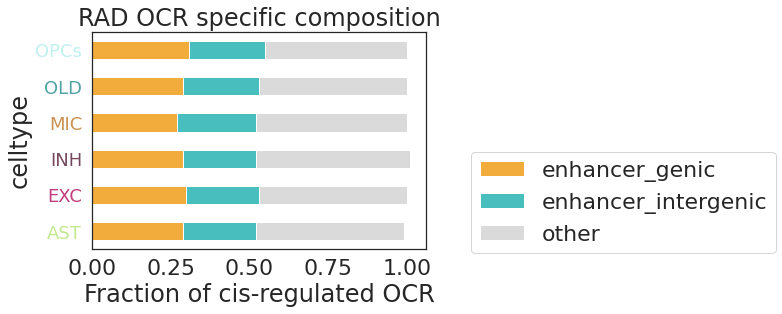

In [39]:
#annot["peakid"] = annot["peakID"].values
annot = adata.var
map_peak2type = {pp:tt for pp,tt in zip(annot["peakid"].values, annot["shortAnnotChip"].values)}
map_peak2nn = {pp:tt for pp,tt in zip(annot["peakid"].values, annot["nearestGeneChip"].values)}
enhancerH = pd.read_csv("./../data/HIPP_merge_enhancer.csv")#72621
enhancerH["peakid"] = enhancerH["chr"].values + "_" + enhancerH["start"].astype(str).values+ "_" + enhancerH["end"].astype(str).values
enhancerH["peakType"] = enhancerH["peakid"].map(map_peak2type).values
enhancerH["peakTypeName"] = enhancerH["peakid"].map(map_peak2nn).values
fil = enhancerH.sort_values('ABC.Score').drop_duplicates('name', keep='last')#16320
fil["class"] = fil["enh_link"].str.split("|",expand=True)[0]

fil
x="logfoldchanges"
pvals_c="pvals_adj"
de_t = df_tot[(df_tot[pvals_c]<= pval)&(np.abs(df_tot[x])>= FC)&(df_tot.brain_region=="HIPP")]

fil_gen = fil[fil["class"] == "genic"]["peakid"].values.tolist()
fil_intergenic = fil[fil["class"] == "intergenic"]["peakid"].values.tolist()
final_compo = pd.DataFrame(columns=["celltype", "enhancer_genic", "enhancer_intergenic", "other"])
celltype=["AST", "EXC", "INH", "MIC", "OLD", "OPCs"]
for ct in celltype:
    tmp = de_t[de_t.celltype ==ct]
    total = float(len(tmp))
    list_pp = tmp["peakid"].values.tolist()
    
    en_G = [it for it in list_pp if it in fil_gen]
    en_I = [it for it in list_pp if it in fil_intergenic]
    other = [it for it in list_pp if it not in fil_gen+fil_intergenic]
    final_compo.loc[len(final_compo),:] = [ct,int(np.round(len(en_G)*100/total,0)), int(np.round(len(en_I)*100/total)), int(np.round(len(other)*100/total))]


final_compo

ff = final_compo.set_index("celltype")
ff /=100.
ax = ff.plot(kind='barh', stacked=True, color=['#f2ac3c', '#48bfbe', "#DADADA"])
color_cond = {"Neur":"#75485E","EXC":"#C23E7E", "INH":"#75485E", "Glials":"#51A3A3","AST-OPCs-OLD":"#51A3A3", "OPCs-Oligo":"#51A3A3","OLD":"#51A3A3","OPCs":"#C0F0F0", "MIC":"#CB904D", "AST":"#C3E991",
               "bulk":"#cccccc", "CTRH":"#B6F2EC", "SPOR":"#F7D7C"}
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    
    x, y = p.get_xy() 
   # ax.annotate(f'{int(height)}%', (x + width/2, y + height*0.5), ha='center')
plt.title("RAD OCR specific composition")
plt.xlabel("Fraction of cis-regulated OCR")
plt.ylabel("celltype")
for label in (ax.get_yticklabels()):
    print(label)
    txt = label.get_text()#.split("|")[1]

    cond = label.get_text()#.split("|")[0]
    label.set(color=color_cond[cond], label=str(txt), fontsize=18)
ax.legend(bbox_to_anchor=(1.1,0.5))
plt.savefig(savepath + "peak_de_composition.svg", bbox_inches="tight")

# GO enhancers

In [40]:
name="nearestGeneChip"
term_list = []
if comp=="promoters":
    background = adata[:, adata.var["shortAnnotChip"] =="Promoters"].var[name].unique().tolist()
    FC=0.5
else:
    background = adata.var[name].unique().tolist()
    FC=0.5

    
dico_li ={"genic":en_G, "intergenic":en_I}
#for ba in ["HIPP"] : #adata.obs.brain_region.unique():
for key,values in dico_li.items():
    df_genic = df_tot[df_tot.peakid.isin(values)]
    for ct in adata.obs.celltype.unique():
        print(ct)
        if ct != "bulk":
            tmp_ada = df_genic[(df_genic.celltype == ct)&(df_genic.pvals_adj<=pval)&(df_genic.brain_region==ba)]
            all_genes = tmp_ada[np.abs(tmp_ada["logfoldchanges"]) >FC ]#["names"].values.tolist()
            if len(all_genes)>0:

                all_genes =all_genes[[name,"logfoldchanges"]]#.set_index(name)
                all_genes = all_genes.sort_values("logfoldchanges", ascending=False)
                #tmp = get_go_prerank(all_genes["logfoldchanges"], background )#[name].values.tolist()
                tmp = get_go(all_genes[name].values.tolist(), background )#

                tmp["celltype"] = ct
                tmp["brain_region"] = ba
                tmp["regulation"] = "all"
                tmp["Type_enhancer"] = key
                term_list.append(tmp)


HIPP
AST
EXC
INH
MIC
OPCs
OLD
HIPP
AST
EXC
INH
MIC
OPCs
OLD


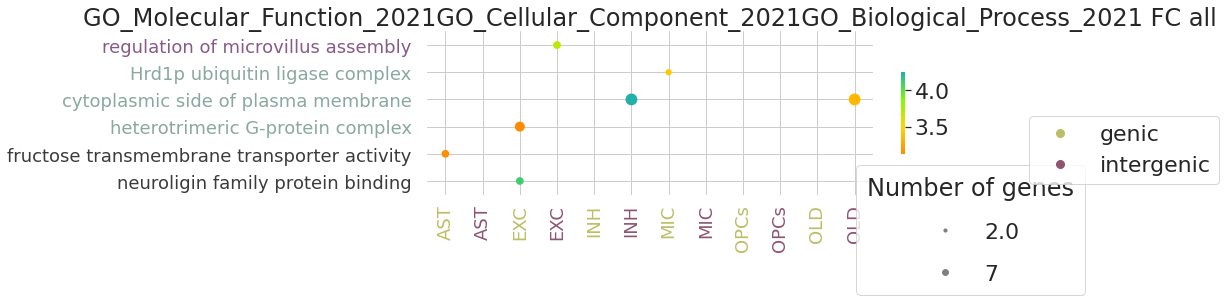

In [41]:
termss = pd.concat(term_list)
#termss = terms_ud
#termss["brain_region"] = "MTG"

termss["comparison"] = "RADvsAll"#%group
termss["-log(p-value)"] = -np.log(termss["Adjusted P-value"].astype(float).values+1e-10)
termss["overlap_ratio"] = termss["Overlap"].str.split("/", expand=True)[0].astype(int) / termss["Overlap"].str.split("/", expand=True)[1].astype(int)
termss["Number of genes"] = termss["Overlap"].str.split("/", expand=True)[0].astype(int) 
score = "overlap_ratio"
min_n =np.abs(termss[score]).min()
max_n =np.abs(termss[score]).max()
#termss["norm_" +score] = np.round((np.abs(termss[score]).values)*100/(max_n)).astype(int)
#termss2 = termss[termss["overlap_ratio"] >=0.0001]
termss2 = termss[termss["Number of genes"] >=2]

termss2 = termss2[termss2["Adjusted P-value"] <0.05]
reg = "all"
plot_GO_2(termss2[(termss2["regulation"]==reg)&(termss2["Gene_set"].str.contains("GO"))],
        ["HIPP"],#"PARL", "CAUD"],
                df_tot[df_tot.celltype != "bulk"]["celltype"].unique().tolist(),
            savepath + "ENH_HIPP_FC_%s_pval%s_GO_0.05"%(FC,pval) + reg, reg,
        score_key = "Number of genes",
                mix_brain_region=False)

# Save BED files for Homer

In [ ]:
x="logfoldchanges"
pvals_c="pvals_adj"
key_annot ="peakid"
df_tot["end"] = df_tot["peakid"].str.split("_", expand=True)[2].values
df_tot["chrm"] = df_tot["peakid"].str.split("_", expand=True)[0].values

if True:
    ###BED files
    beddir = os.path.join(savepath, "bed_diff/")
    if not os.path.exists(beddir):
        os.mkdir(beddir)

    brain_regions = df_tot.brain_region.unique() #"HIPP"
    celltypes = df_tot.celltype.unique() #"Glials"
    columns = ["chrm", "start","end", "strand"]
    for ba in brain_regions:
        for ct in celltypes:
                tt = df_tot[(df_tot.celltype==ct) 
                       & (df_tot.brain_region == ba) 
                       & (np.abs(df_tot[x])>=FC)
                       &  (df_tot[pvals_c]<=pval) 
                   # & (df_tot.peakType.isin(['Exonic', 'Promoter', 'Intronic']))
                       ].sort_values(pvals_c, ascending=False)
                cond_tt1 = tt[ tt[x]>=FC]
                list_genes_1 = cond_tt1[key_annot].tolist()

                cond_tt2 = tt[ tt[x]<=-FC]
                list_genes_2 = cond_tt2[key_annot].tolist()
                tt["strand"] = "."
                print(len(list_genes_2)+len(list_genes_1))
                tt[columns].to_csv(beddir+ key_annot+ ct + ba+ "genes_de_with_logFC" + str(FC)+ str(pval) +".bed", index=None, header=None, sep="\t")
tto = df_tot[(df_tot.celltype==ct) & (df_tot.brain_region == ba) ].sort_values(pvals_c, ascending=False)
tto["strand"] = "."
tto[columns].to_csv(beddir+ key_annot +"all.bed", index=None, header=None, sep="\t")
